<a href="https://colab.research.google.com/github/der-himmel/toi_7sem/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

Параметры модели  

In [2]:
np.random.seed(307)

theta0 = 1.0
theta1 = 2.0
theta2 = 3.0
sigma_squared = 0.1
T = 10
delta_t = 0.1

Начальные оценки параметров Theta1 и Theta2 для РМНК

In [3]:
theta_estimate_rls = np.array([0.5, 0.5])  # начальные приближения
P_initial = np.eye(2) * 100  # начальная ковариационная матрица для РМНК

Истинная модель

In [4]:
def true_output(t):
    return theta0 + theta1 * t + theta2 * t ** 2

Генерация временных шагов и шумных измерений

In [5]:
time_steps = np.arange(0, T, delta_t)
noise = np.random.normal(0, np.sqrt(sigma_squared), len(time_steps))
measurements = true_output(time_steps) + noise

Реализация рекурсивного метода наименьших квадратов (РМНК)

In [6]:
P_rls = P_initial.copy()
theta_history_rls = []
estimated_outputs_rls = []
approximations_rls = []  # Для сохранения промежуточных аппроксимаций для визуализации
colors = plt.cm.Reds(np.linspace(0.2, 1, min(30, len(time_steps))))  # Цвета для каждого измерения

РМНК для каждого измерения

In [7]:
for i, t in enumerate(time_steps):
    # Вектор регрессии (без Theta0)
    C = np.array([t, t ** 2]).reshape(1, -1)

    # Оценка выхода для текущего времени с фиксированным Theta0
    estimated_output = theta0 + C @ theta_estimate_rls
    estimated_outputs_rls.append(estimated_output[0])  # добавляем оценку

    # Ошибка между измерением и моделью
    error = measurements[i] - estimated_output

    # Вычисление матрицы S
    S = C @ P_rls @ C.T + sigma_squared

    # Коэффициент усиления K
    K = (P_rls @ C.T) / S

    # Обновление оценок параметров Theta1 и Theta2
    theta_estimate_rls = theta_estimate_rls + K.flatten() * error
    theta_history_rls.append(theta_estimate_rls.copy())

    # Обновление ковариационной матрицы
    P_rls = (P_rls - K @ C @ P_rls)

    # Сохраняем аппроксимированные функции и точки измерений для визуализации (только для первых 30 измерений)
    if i < 15:
        approximations_rls.append((theta_estimate_rls.copy(), measurements[:i + 1], time_steps[:i + 1], colors[i]))

theta_history_rls = np.array(theta_history_rls)

Обычный метод наименьших квадратов (МНК)

In [8]:
X = np.column_stack((time_steps, time_steps ** 2))
y = measurements - theta0  # Изменяем y, чтобы исключить Theta0
theta_ols = inv(X.T @ X) @ X.T @ y  # Закрытая формула для МНК

**Графики**

1. График последовательных аппроксимаций РМНК для первых 30 измерений

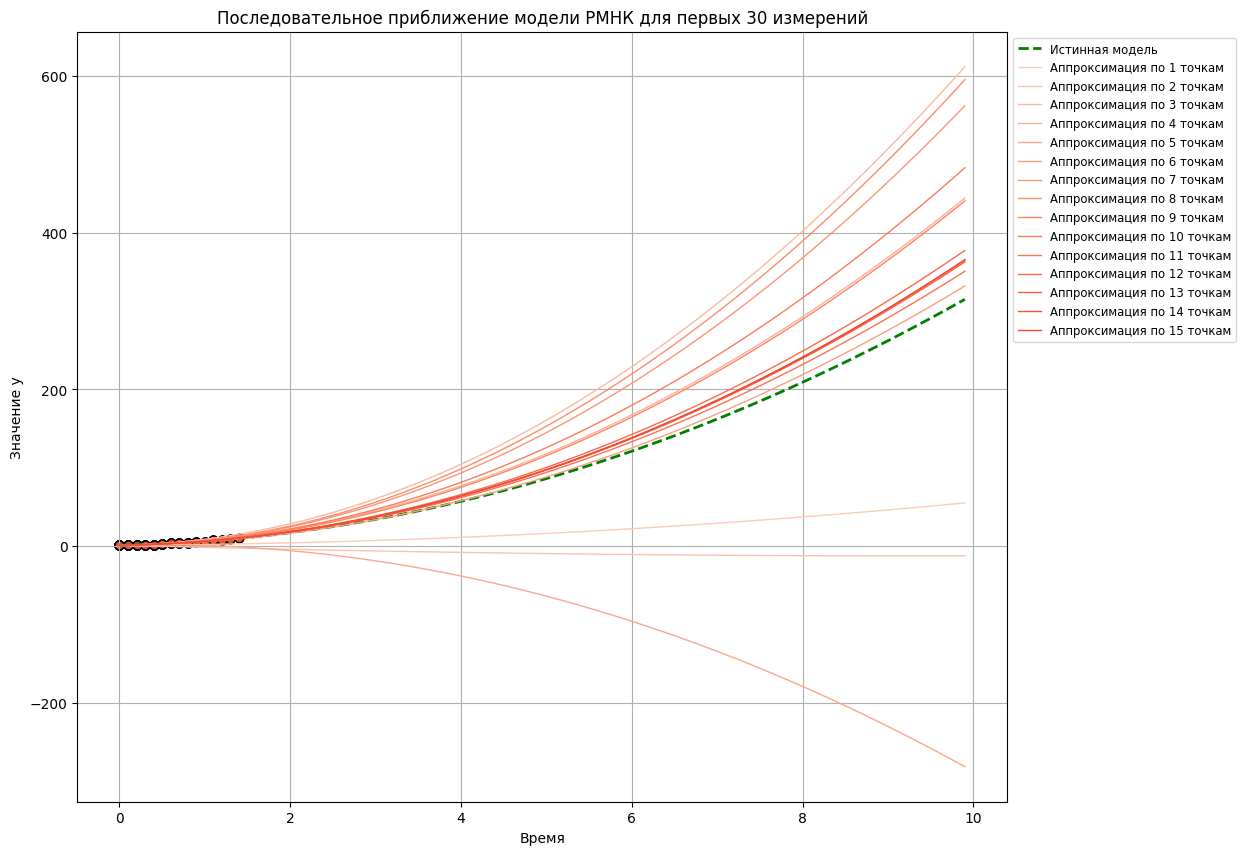

In [15]:
plt.figure(figsize=(12, 10))

# Истинная модель (пунктирная линия)
plt.plot(time_steps, true_output(time_steps), 'g--', label="Истинная модель", linewidth=2)

# Аппроксимации РМНК и точки измерений на каждом шаге
for theta, y_points, t_points, color in approximations_rls:
    approximated_values = theta0 + theta[0] * time_steps + theta[1] * time_steps ** 2
    plt.plot(time_steps, approximated_values, '-', linewidth=1, color=color,
             label=f"Аппроксимация по {len(t_points)} точкам")
    plt.scatter(t_points, y_points, color=color, s=40, edgecolor='black')  # точки измерений

plt.xlabel("Время")
plt.ylabel("Значение y")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize='small')
plt.title("Последовательное приближение модели РМНК для первых 30 измерений")
plt.grid(True)
plt.show()

2. Полный график сравнения данных для РМНК

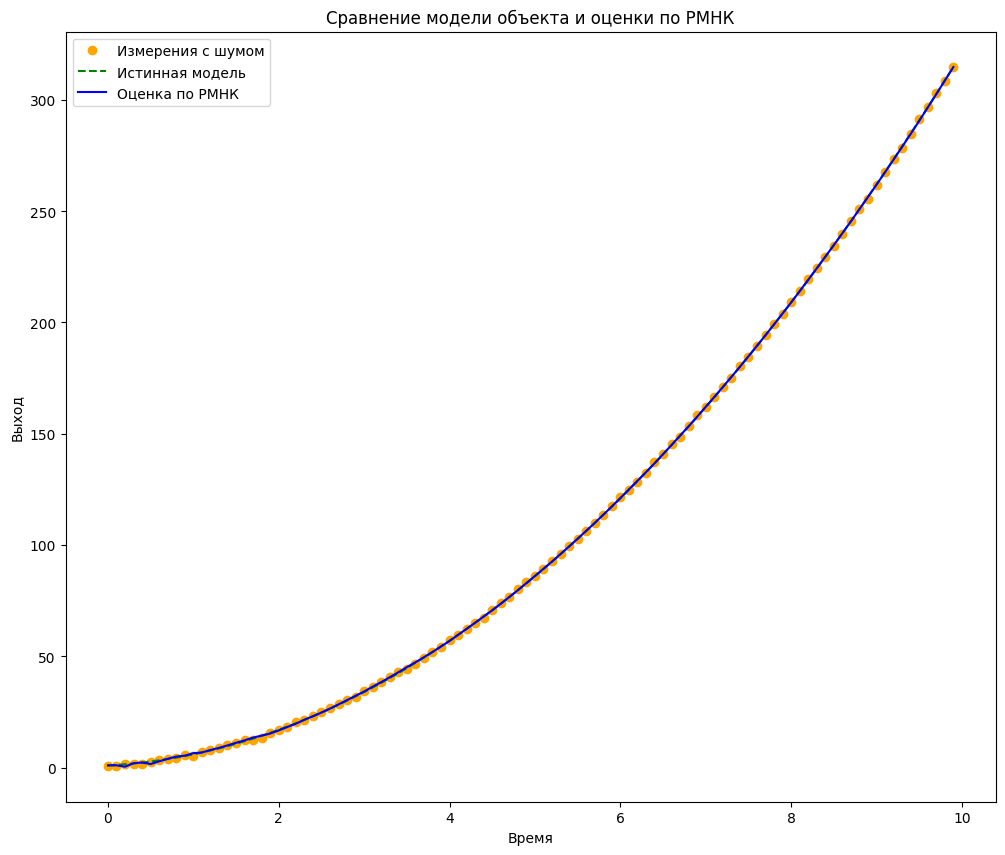

In [16]:
plt.figure(figsize=(12, 10))

# Исходные данные с шумом
plt.plot(time_steps, measurements, 'o', label="Измерения с шумом", color="orange")
# Истинная модель
plt.plot(time_steps, true_output(time_steps), 'g--', label="Истинная модель")
# Оценка модели по РМНК
plt.plot(time_steps, estimated_outputs_rls, 'b-', label="Оценка по РМНК")

plt.xlabel("Время")
plt.ylabel("Выход")
plt.legend()
plt.title("Сравнение модели объекта и оценки по РМНК")
plt.show()

3. График изменения оценок параметров Theta1 и Theta2

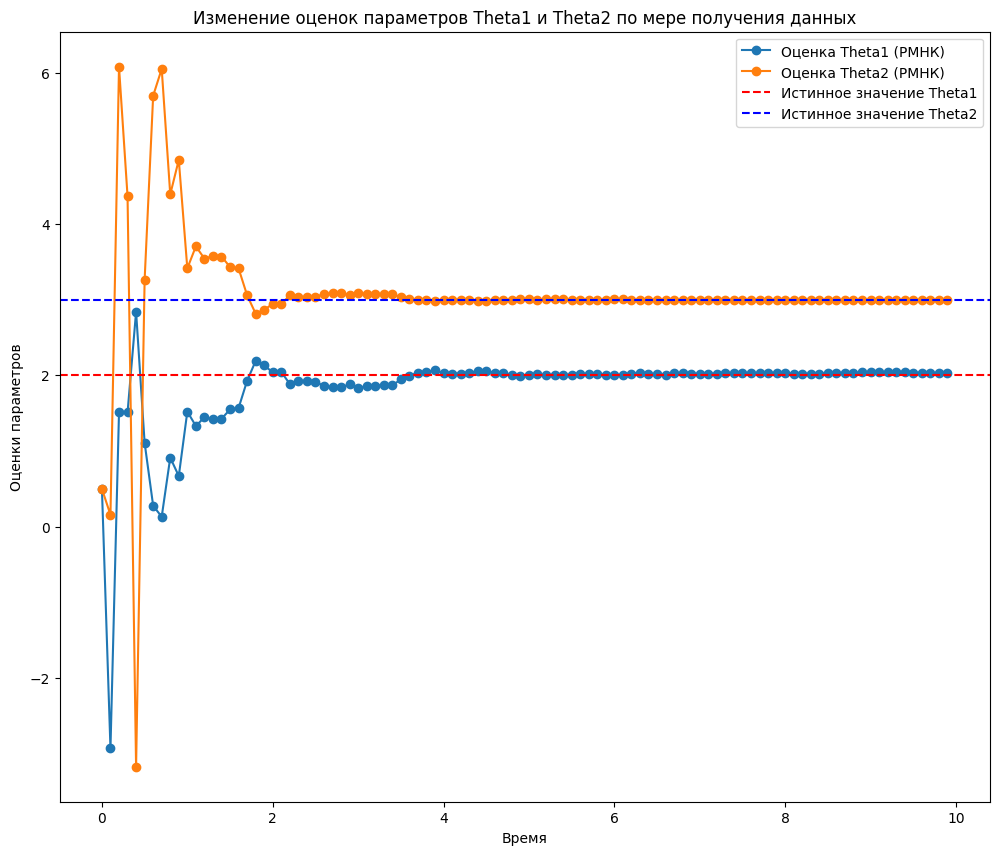

In [17]:
plt.figure(figsize=(12, 10))
plt.plot(time_steps, theta_history_rls[:, 0], label="Оценка Theta1 (РМНК)", marker='o')
plt.plot(time_steps, theta_history_rls[:, 1], label="Оценка Theta2 (РМНК)", marker='o')
plt.axhline(y=theta1, color='r', linestyle='--', label="Истинное значение Theta1")
plt.axhline(y=theta2, color='b', linestyle='--', label="Истинное значение Theta2")

plt.xlabel("Время")
plt.ylabel("Оценки параметров")
plt.legend()
plt.title("Изменение оценок параметров Theta1 и Theta2 по мере получения данных")
plt.show()

4. График отклонений от истинных значений для Theta1 и Theta2 по итерациям

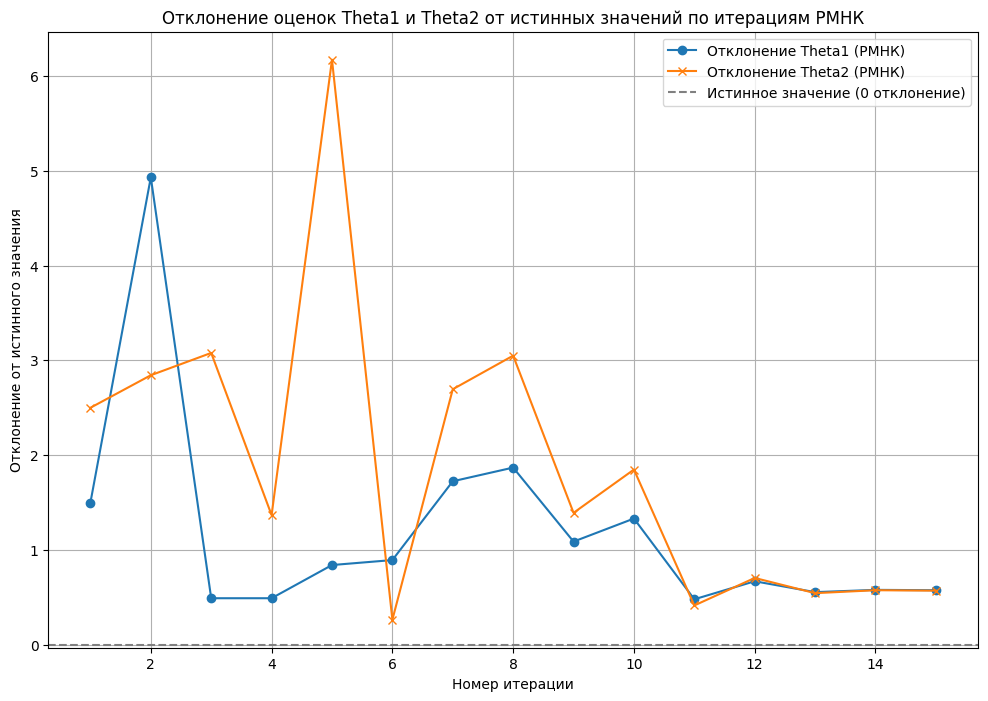

In [12]:
iterations = min(15, len(theta_history_rls))  # Ограничиваем первыми 30 итерациями

deviation_theta1 = np.abs(theta1 - theta_history_rls[:iterations, 0])
deviation_theta2 = np.abs(theta2 - theta_history_rls[:iterations, 1])

plt.figure(figsize=(12, 8))
plt.plot(range(1, iterations + 1), deviation_theta1, label="Отклонение Theta1 (РМНК)", marker='o')
plt.plot(range(1, iterations + 1), deviation_theta2, label="Отклонение Theta2 (РМНК)", marker='x')
plt.axhline(y=0, color='grey', linestyle='--', label="Истинное значение (0 отклонение)")
plt.xlabel("Номер итерации")
plt.ylabel("Отклонение от истинного значения")
plt.legend()
plt.title("Отклонение оценок Theta1 и Theta2 от истинных значений по итерациям РМНК")
plt.grid(True)
plt.show()

Финальные оценки РМНК и вывод результатов

In [13]:
final_theta_estimate_rls = theta_history_rls[-1]

# Вывод результатов
print("Финальные оценки параметров РМНК (Theta1 и Theta2):")
print("Theta1 (РМНК):", final_theta_estimate_rls[0])
print("Theta2 (РМНК):", final_theta_estimate_rls[1])

print("\nОценки параметров МНК (Theta1 и Theta2):")
print("Theta1 (МНК):", theta_ols[0])
print("Theta2 (МНК):", theta_ols[1])

print("\nИстинные значения для сравнения:")
print(f"Theta1: {theta1}, Theta2: {theta2}")

# Отклонения от истинных значений
print("\nОтклонения от истинных значений:")
print(f"Отклонение Theta1 (РМНК): {abs(theta1 - final_theta_estimate_rls[0])}")
print(f"Отклонение Theta2 (РМНК): {abs(theta2 - final_theta_estimate_rls[1])}")
print(f"Отклонение Theta1 (МНК): {abs(theta1 - theta_ols[0])}")
print(f"Отклонение Theta2 (МНК): {abs(theta2 - theta_ols[1])}")

Финальные оценки параметров РМНК (Theta1 и Theta2):
Theta1 (РМНК): 2.027080221066114
Theta2 (РМНК): 2.9965946164523927

Оценки параметров МНК (Theta1 и Theta2):
Theta1 (МНК): 2.027086134660156
Theta2 (МНК): 2.9965938863144195

Истинные значения для сравнения:
Theta1: 2.0, Theta2: 3.0

Отклонения от истинных значений:
Отклонение Theta1 (РМНК): 0.027080221066114074
Отклонение Theta2 (РМНК): 0.0034053835476073324
Отклонение Theta1 (МНК): 0.02708613466015608
Отклонение Theta2 (МНК): 0.003406113685580525
